In [1]:
import math
import optuna
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import (StratifiedKFold,
train_test_split, cross_val_score, KFold)
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import (RandomForestClassifier, HistGradientBoostingClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier, 
                              StackingClassifier, BaggingClassifier,VotingClassifier)
from sklearn.metrics import accuracy_score, f1_score, auc
from sklearn.decomposition import TruncatedSVD

from sklearn.preprocessing import MinMaxScaler, StandardScaler,PowerTransformer

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')
sub  = pd.read_csv('/kaggle/input/playground-series-s5e3/sample_submission.csv')
original = pd.read_csv('/kaggle/input/rainfall-prediction-using-machine-learning/Rainfall.csv')

In [4]:
train.head(1)

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1


In [5]:
train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)

original['rainfall']=original['rainfall'].map({'yes': 1, 'no': 0})
original.columns = [f.strip() for f in original.columns]

train_df = train.copy()
test_df = test.copy()
original_df = original.copy()

In [6]:
print(f'Shape of train data: {train.shape}')
print(f'Shape of test data : {test.shape}')

Shape of train data: (2190, 12)
Shape of test data : (730, 11)


In [7]:
train_df['original']=0
test_df['original']=0

original_df['original']=1

train_data = pd.concat([train_df, original_df], axis=0)
train_data.reset_index(inplace=True, drop=True)

# Analysis

In [8]:
train_data.describe().T\
.style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
.background_gradient(subset=['std'], cmap='Blues')\
.background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
day,2556.000000,156.437402,113.147285,1.000000,44.000000,148.000000,255.000000,365.000000
pressure,2556.000000,1013.622261,5.769101,998.500000,1008.600000,1013.000000,1017.800000,1034.600000
maxtemp,2556.000000,26.340806,5.700976,7.100000,21.300000,27.800000,31.200000,36.300000
temparature,2556.000000,23.923592,5.282473,4.900000,19.300000,25.500000,28.400000,32.400000
mintemp,2556.000000,22.130634,5.138897,3.100000,17.600000,23.800000,26.500000,30.000000
dewpoint,2556.000000,20.387911,5.396788,-0.400000,16.800000,22.100000,25.000000,26.700000
humidity,2556.000000,81.770344,8.186720,36.000000,77.000000,81.000000,87.000000,98.000000
cloud,2556.000000,75.064163,18.678173,0.000000,68.000000,83.000000,88.000000,100.000000
sunshine,2556.000000,3.841080,3.678826,0.000000,0.400000,2.400000,7.000000,12.100000
winddirection,2555.000000,104.383679,80.242979,10.000000,40.000000,70.000000,200.000000,350.000000


In [9]:
num_cols=[col for col in test_df.columns]
target_col='rainfall'

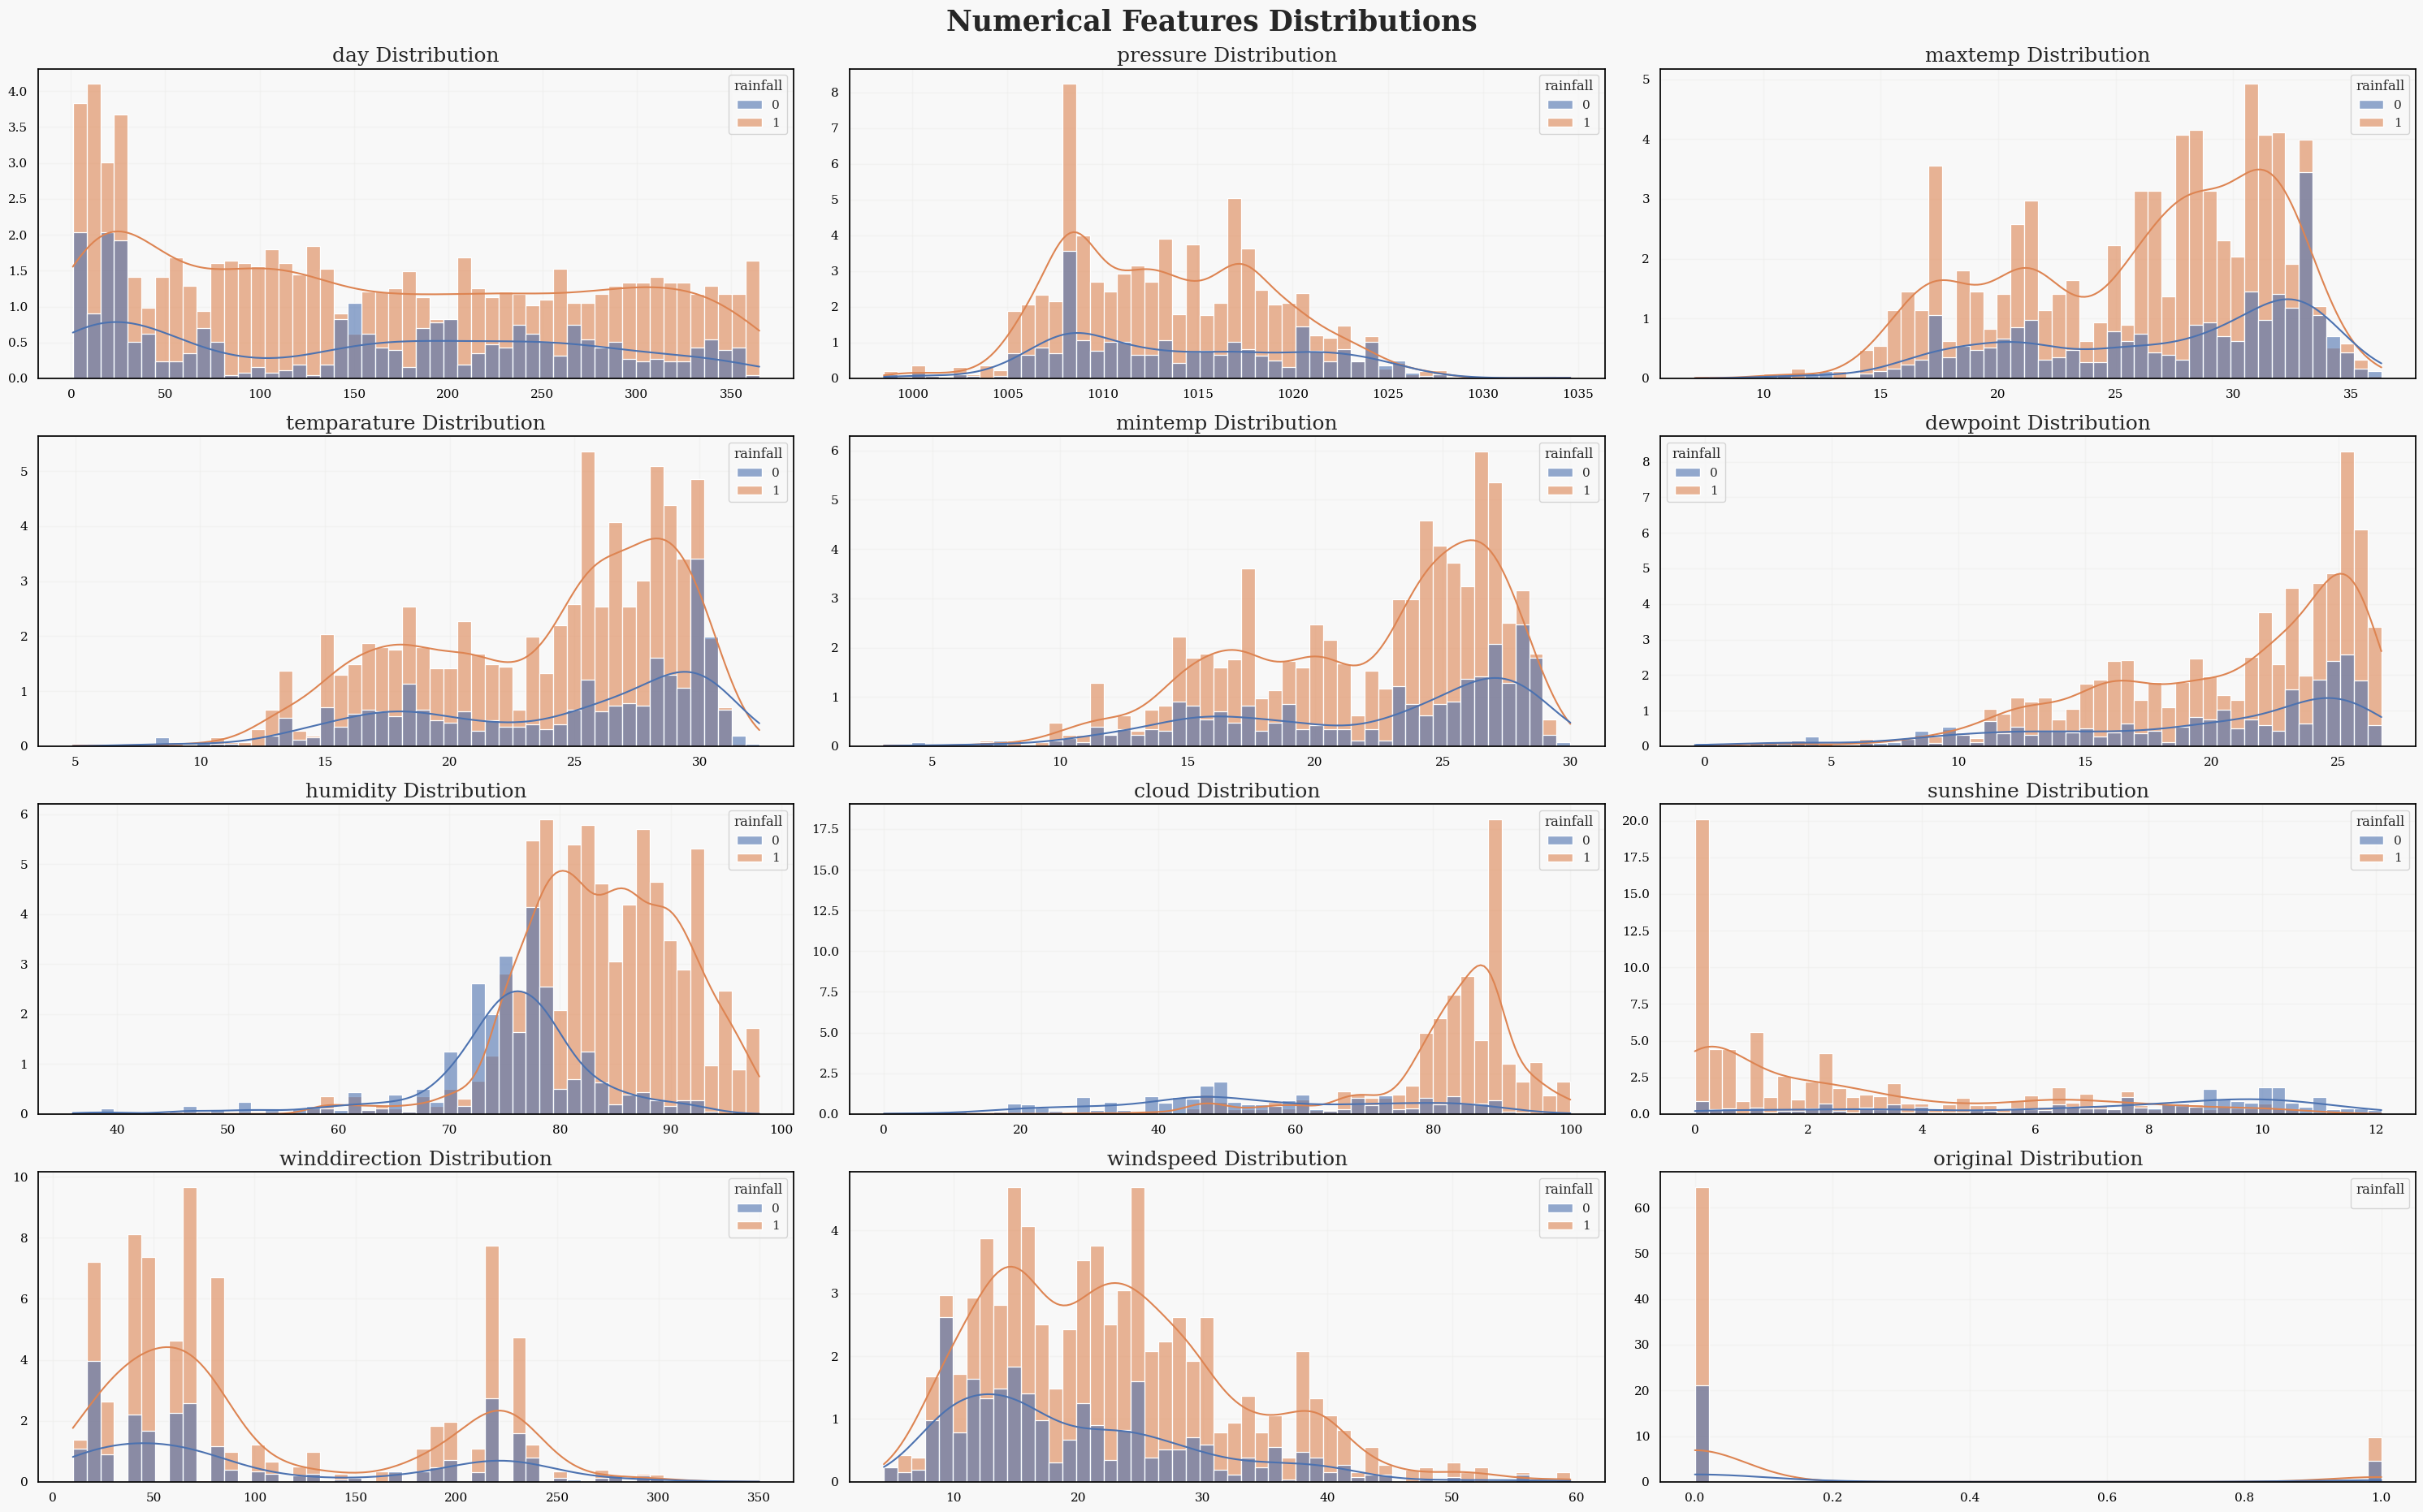

In [10]:
BINS=50
COLS=3
target='rainfall'
ROWS=math.ceil(len(num_cols)/COLS)

histplot_hyperparams={'kde':True, 'alpha':0.6,'stat' : 'percent','bins' : BINS}

fig, ax = plt.subplots(ROWS, COLS, figsize=(30, 20))
ax=ax.ravel()

for i, column in enumerate(num_cols):
    plot_axes=[ax[i]]
    sns.histplot(train_data, x=column, hue=target, ax=ax[i], color=palette[1], **histplot_hyperparams)
    ax[i].set_title(f'{column} Distribution', fontsize=18)
    ax[i].set_xlabel(None, fontsize=16)  
    ax[i].set_ylabel(None, fontsize=16)

handles, labels = ax[0].get_legend_handles_labels()
plt.legend(handles, labels, title=target_col)

for i in range(i + 1, len(ax)):
    ax[i].axis('off')

fig.suptitle(f'Numerical Features Distributions\n\n\n', ha='center', fontweight='bold', fontsize=25, y=0.93)
plt.tight_layout()
plt.show()

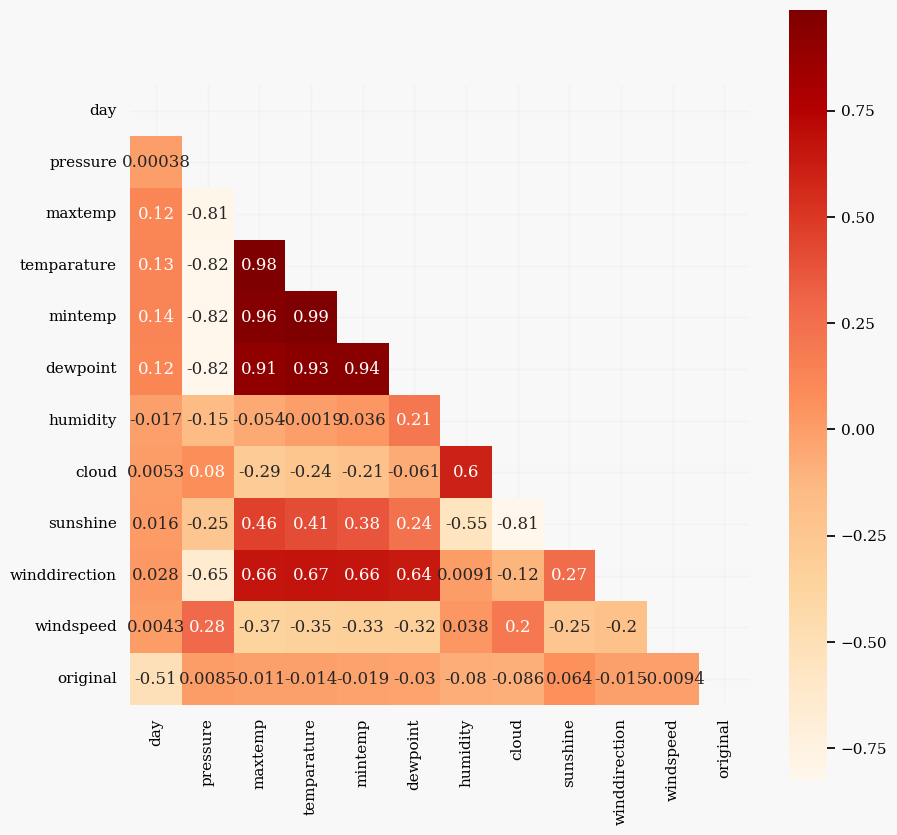

In [11]:
corr = train_data[num_cols].corr()
mask = np.triu(np.ones_like(corr, dtype='bool'))
plt.figure(figsize=(10, 10))

heatmap=sns.heatmap(corr, mask=mask, annot=True, square=True, cmap='OrRd')

**Key Points**
- this heatmap support the correlation that we obtained through pairplot `maxtemp`, `mintemp`, `temp`, `dewpoint` are highly correlated.
- `humidity` is positively correlated with `windspeed(62%)`, with `cloud(58%)`
- `sunshine` is positively correlated with `maxtemp(45%)`, `temp(41%)`, `mintemp(38%)`

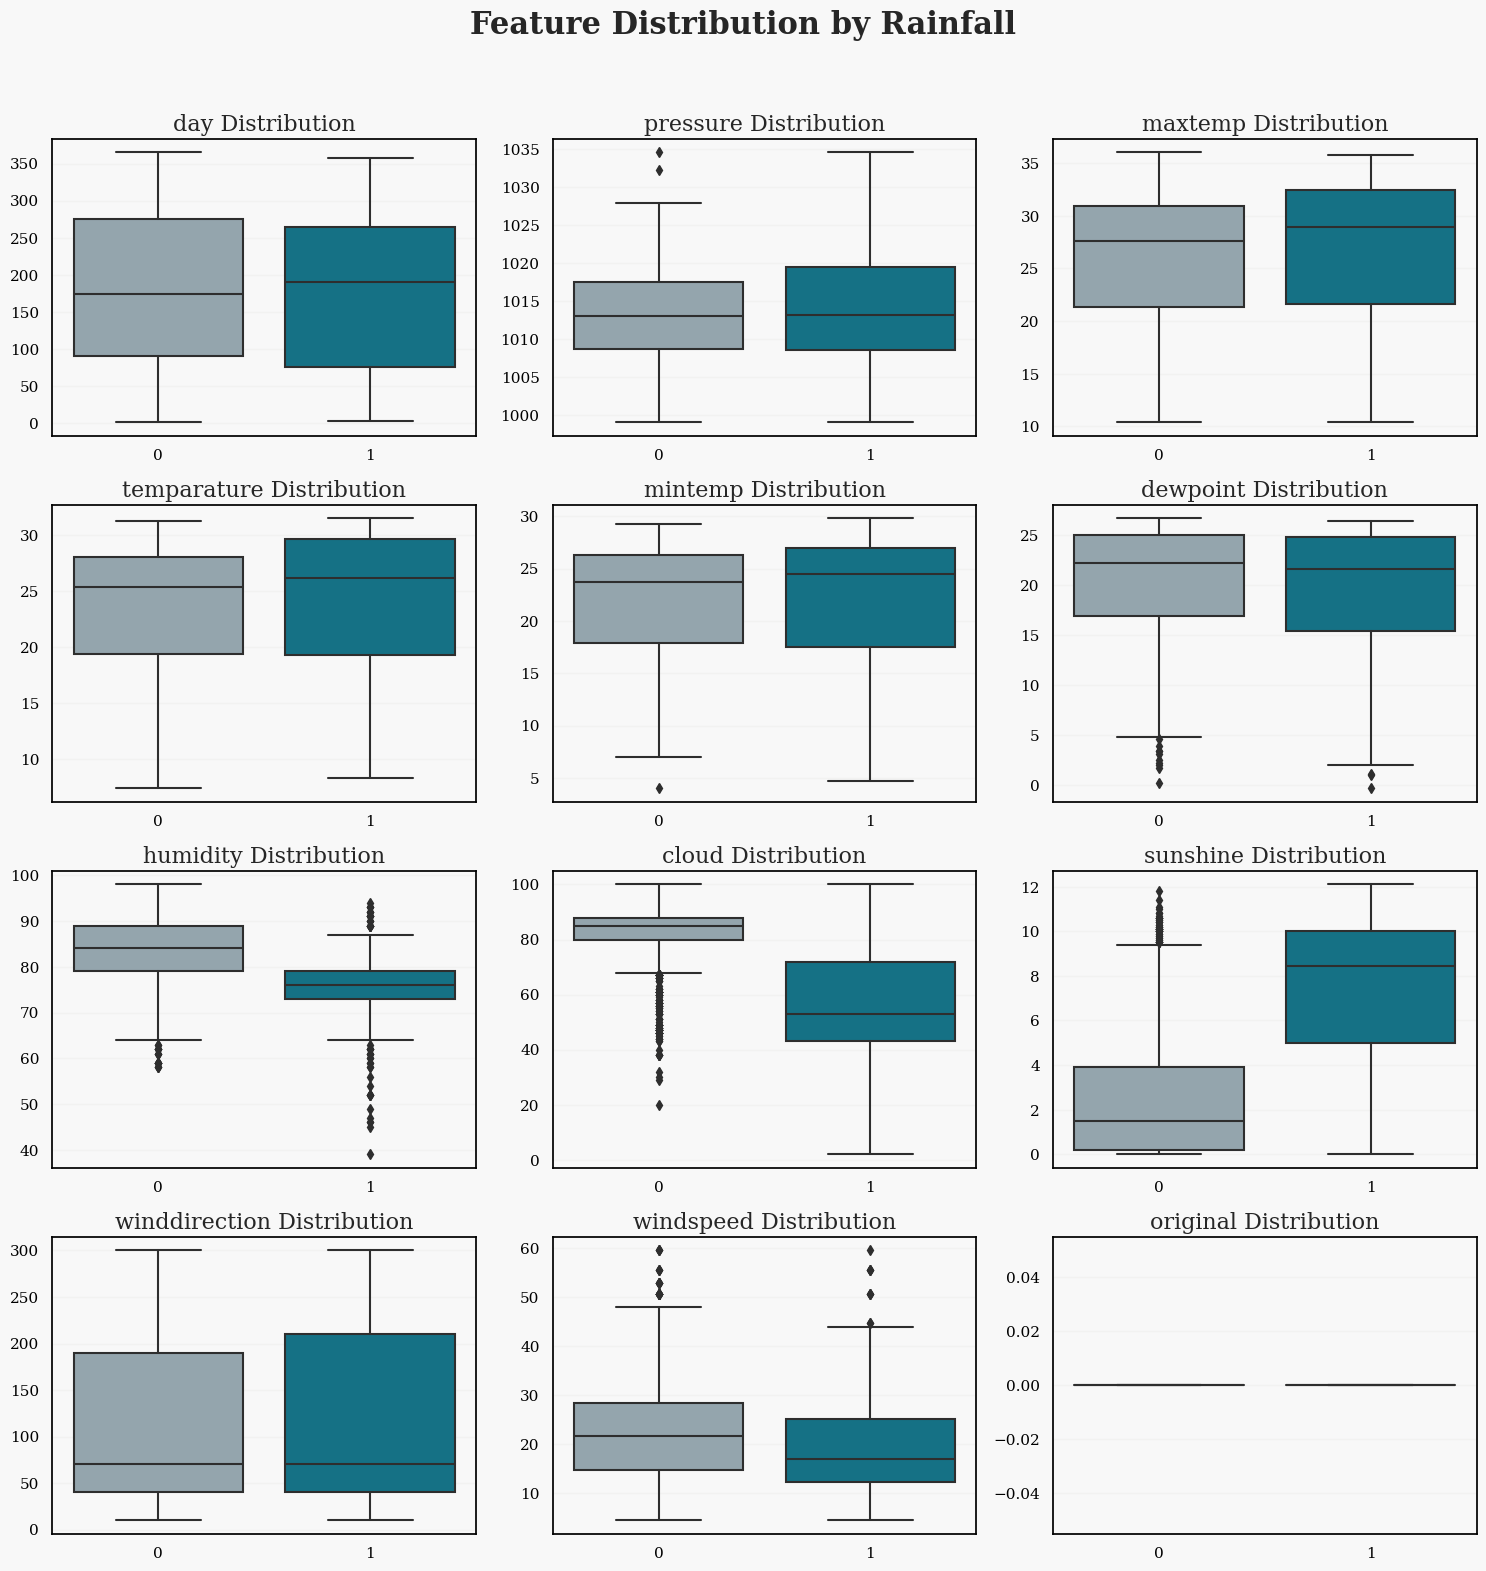

In [12]:
c = ['#90A6B1', '#037d97']
unique_target=train_df[target_col].unique()
n_categories=len(unique_target)
colors = sns.color_palette(c, n_categories)

fig, ax = plt.subplots(ROWS, COLS, figsize=(15, 4 * ROWS))
ax = ax.ravel()

for i, column in enumerate(num_cols):
    data = [train_df[train_df[target_col]==target][column] for target in unique_target]
    sns.boxplot(data=data, ax=ax[i], palette=colors)
    ax[i].set_title(f'{column} Distribution', fontsize=16)
    ax[i].set_xlabel(None, fontsize=18)
    ax[i].set_ylabel(None, fontsize=18)

for i in range(len(num_cols), len(ax)):
    ax[i].axis('off')

fig.suptitle(f'Feature Distribution by Rainfall\n\n', ha='center', fontweight='bold', fontsize=22)
plt.tight_layout(pad=1.0)
plt.show()

# Feature Engineering

- Min-max scaling based solely on the training data might be problematic if the test data contains extreme values. Hence, adjusting the denominator using the overall minimum and maximum is recommended.

- Function for one hot encoding, it first combines the data so that no category is missed and the category with least frequency is dropped because of redundancy

In [13]:
def min_max_scaling(train, test, column):
    scaler = MinMaxScaler()
    max_val = max(train[column].max(), test[column].max())
    min_val = max(train[column].min(), test[column].min())

    train[column]=(train[column]-min_val)/(max_val-min_val)
    test[column] =(test[column]-min_val)/(max_val-min_val)

    return train, test

def one_hot_encoding(train, test, cols, target):
    combined=pd.concat([train, test], axis=0)

    for col in cols:
        one_hot = pd.get_dummies(combined[col])
        counts = combined[col].value_counts()
        min_count_cat = counts.idxmin()
        one_hot = one_hot.drop(min_count_cat, axis=1)
        one_hot.columns = [str(oh)+col+'_OHE' for oh in one_hot.columns]

        combined = pd.concat([combined, one_hot], axis='columns')
        combined = combined.loc[:, ~combined.columns.duplicated()]

    train_ohe = combined[:len(train)]
    test_ohe  = combined[len(train):]

    test_ohe.reset_index(inplace=True, drop=True)
    test_ohe.drop(columns=['rainfall'], inplace=True)
    return train_ohe, test_ohe

### 4.1 Impute Missing Values

- For the consistency we apply the imputation techniques only on the common features in both training and test dataset.

- **SVD** can capture the most important features and reduce the dimensions while retaining most of the information. because in higher dimensional data, many features may be redundant or noisy.

In [14]:
def handle_missing_values(train_df, test_df, target="rainfall", n_components=1):   
    train_processed = train_df.copy()
    test_processed = test_df.copy()
    
    # Handle the target column
    y_train = None
    if target in train_df.columns:
        y_train = train_processed[target].copy()
        train_processed = train_processed.drop(columns=[target])
    
    # Get feature columns (excluding target)
    train_features = train_processed.columns.tolist()
    
    # Get common features between train and test
    common_features = [col for col in train_features if col in test_df.columns]
    
    # Only use common features for imputation to ensure consistency
    train_subset = train_processed[common_features]
    test_subset = test_processed[common_features]
    
    # Step 1: Imputation - Create simple imputer for numeric columns
    numeric_imputer = SimpleImputer(strategy='median')
    
    # Fit imputer only on common features
    numeric_imputer.fit(train_subset)
    
    # Transform both datasets
    train_imputed_values = numeric_imputer.transform(train_subset)
    test_imputed_values = numeric_imputer.transform(test_subset)
    
    # Create DataFrames from imputed values
    train_imputed = pd.DataFrame(
        train_imputed_values,
        columns=common_features,
        index=train_processed.index
    )
    
    test_imputed = pd.DataFrame(
        test_imputed_values,
        columns=common_features,
        index=test_processed.index
    )
    
    # Add back non-common features to train (not imputed)
    non_common_features = [col for col in train_features if col not in common_features]
    for col in non_common_features:
        train_imputed[col] = train_processed[col]
    
    # Step 2: Create missing value indicators for common features
    indicator_cols = []
    for col in common_features:
        indicator_name = f'{col}_missing'
        train_imputed[indicator_name] = train_df[col].isna().astype(int)
        test_imputed[indicator_name] = test_df[col].isna().astype(int)
        indicator_cols.append(indicator_name)
    
    # Step 3: Apply SVD to combine indicator columns into fewer dimensions
    if indicator_cols and len(indicator_cols) > 1:  # Only apply SVD if we have multiple indicators
        # Initialize SVD with specified number of components
        svd = TruncatedSVD(n_components=min(n_components, len(indicator_cols)))
        
        # Fit SVD on training data indicators and transform both datasets
        missing_indicators_train = train_imputed[indicator_cols].values
        missing_indicators_test = test_imputed[indicator_cols].values
        
        # Only proceed with SVD if we have missing values
        if np.any(missing_indicators_train):
            # Fit and transform
            missing_svd_train = svd.fit_transform(missing_indicators_train)
            missing_svd_test = svd.transform(missing_indicators_test)
            
            # Add SVD components to the datasets
            for i in range(n_components):
                train_imputed[f'missing_svd_{i}'] = missing_svd_train[:, i]
                test_imputed[f'missing_svd_{i}'] = missing_svd_test[:, i]
            
            # Optionally drop the original indicator columns if they're no longer needed
            train_imputed.drop(columns=indicator_cols, inplace=True)
            test_imputed.drop(columns=indicator_cols, inplace=True)
    
    # Add back the target column to the training data if it existed
    if y_train is not None:
        train_imputed[target] = y_train
    
    return train_imputed, test_imputed
    
train_imputed, test_imputed = handle_missing_values(train_data, test_df, n_components=1)

In [15]:
train_imputed['missing_svd_0'].max()

1.414213562373095

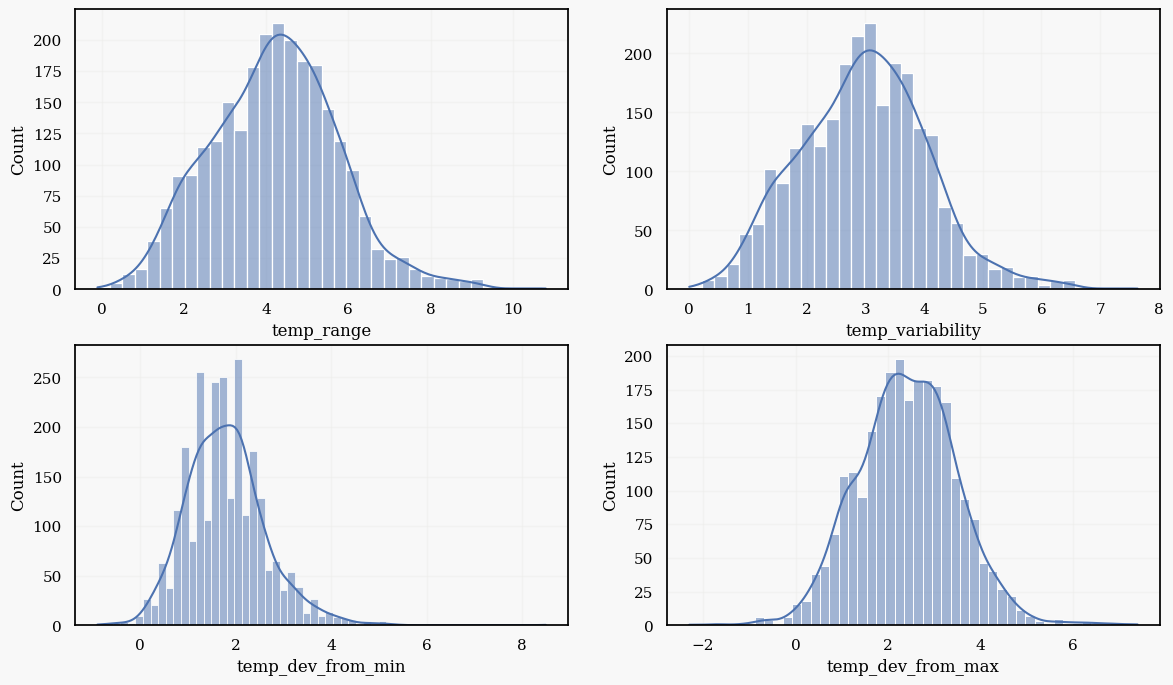

In [16]:
def new_temp_col(data):
    # data=data.copy()
    data['temp_range']=data['maxtemp']-data['mintemp']
    data['temp_variability'] =data[['maxtemp', 'mintemp']].std(axis=1)
    data['temp_dev_from_min']=data['temparature']-data['mintemp']
    data['temp_dev_from_max']=data['maxtemp'] - data['temparature']
    data['temp_avg'] = data[['maxtemp', 'temparature', 'mintemp']].mean(axis=1)
    return data

train_fe = new_temp_col(train_imputed)
test_fe  = new_temp_col(test_imputed)

new_temp_col=[col for col in train_fe.columns if col.startswith('temp_')]

fig, ax=plt.subplots(2,2,figsize=(14,8))
ax=ax.ravel()
for i,col in enumerate(new_temp_col):
    if i>=4:
        break
    sns.histplot(data=train_fe, x=col, ax=ax[i], kde=True)

- Since temparature, mintemp and maxtemp are highly related with each other that we shown through pair plot and correlation heatmap, so this feature can capture daily temperature variations.
- `temp_dev_from_min` measures how much the daily temperature deviates from the minimum temparature. higher value indicates greature temperature fluctuation, which can be helpful for understanding weather variability and similar for `temp_dev_from_max`

**Note**
- all new temp features are nearly normal which is worthable for our model building

**wind chill**
- the wind chill effect occurs because wind removes heat from the body more quickly than still air, making it feel colder than the actual temparature.
- this is standard formula used by the `meteorological services of Canada`

In [17]:
def get_season(month):
    if month in [12, 1, 2]:
        return 0 
    elif month in [3, 4, 5]:
        return 1 
    elif month in [6, 7, 8]:
        return 2 
    else:
        return 3 

def some_other_features(data):
    data = data.copy()
    
    data['month'] = ((data['day']-1)//30)+1
    data['season']=data['month'].apply(get_season)
    data['day_of_week']=(data['day']-1)%7
    data['is_weekend'] =data['day_of_week'].isin([5,6]).astype(int)

    data['day_of_year_sin'] = np.sin(2 * np.pi * data['day'] / 365)
    data['day_of_year_cos'] = np.cos(2 * np.pi * data['day'] / 365)
    
    data['wind_effect']=data['windspeed']*data['winddirection']

    data['humidity_level'] = data['temparature']-data['dewpoint']
    
    data['cloud_sun_ratio'] = data['cloud']/(data['sunshine']+1)
    data['temp_humidity'] = data['temparature']*data['humidity']
    
    data['temp_humidity_interaction'] = data['temp_avg'] * data['humidity']
    data['dew_cloud_interaction'] = data['humidity_level'] * data['cloud']
    data['sun_wind_interaction'] = data['sunshine'] * data['windspeed']

    # wind direction
    data['wind_dir_rad'] = np.deg2rad(data['winddirection'])
    data['wind_dir_sin'] = np.sin(data['wind_dir_rad'])
    data['wind_dir_cos'] = np.cos(data['wind_dir_rad'])
    data.drop(columns=['wind_dir_rad'], inplace=True)

    # Rolling statistical features mean
    for w in [3, 7, 14]:
        data[f'rolling_temp_mean_{w}d'] = data['temp_avg'].rolling(window=w, min_periods=1).mean()
        data[f'rolling_wind_mean_{w}d'] = data['windspeed'].rolling(window=w, min_periods=1).mean()
        data[f'rolling_humidity_mean{w}d']=data['humidity'].rolling(window=w, min_periods=1).mean()
        data[f'rolling_pressure_mean{w}d']=data['pressure'].rolling(window=w, min_periods=1).mean()
        data[f'rolling_cloud_mean{w}d'] = data['cloud'].rolling(window=w, min_periods=1).mean()

    
    # 16. Moving standard deviations for measuring variability
    for w in [7, 14]:
        data[f'temp_std_{w}d'] = data['temparature'].rolling(window=w, min_periods=4).std().fillna(0)
        data[f'pressure_std_{w}d'] = data['pressure'].rolling(window=w, min_periods=4).std().fillna(0)
        data[f'humidity_std_{w}d'] = data['humidity'].rolling(window=w, min_periods=4).std().fillna(0)

    # Extreme weather indicators
    data['extreme_temp'] = (data['temparature'] > data['temparature'].quantile(0.95)) | (data['temparature'] < data['temparature'].quantile(0.05))
    data['extreme_temp'] = data['extreme_temp'].astype(int)
    
    data['extreme_humidity'] = (data['humidity'] > data['humidity'].quantile(0.95)) | (data['humidity'] < data['humidity'].quantile(0.05))
    data['extreme_humidity'] = data['extreme_humidity'].astype(int)

    data['extreme_pressure'] = (data['pressure'] > data['pressure'].quantile(0.95)) | (data['pressure'] < data['pressure'].quantile(0.05))
    data['extreme_pressure'] = data['extreme_pressure'].astype(int)

    # Lag Features
    data['temp_lag_1'] = data['temp_avg'].shift(1)
    data['humidity_lag_1'] = data['humidity'].shift(1)
    data['windspeed_lag_1'] = data['windspeed'].shift(1)

    # Wind chill factor 
    data['wind_chill'] = 13.12 + 0.6215 * data['temparature'] - 11.37 * (data['windspeed']**0.16) + 0.3965 * data['temparature'] * (data['windspeed']**0.16)
    
    return data

train_fe = some_other_features(train_fe)
test_fe = some_other_features(test_fe)

test_fe.fillna(test_fe.mean(), inplace=True)
train_fe.fillna(train_fe.mean(), inplace=True)

# Feature Selection

In [18]:
NUMS = [col for col in test_fe.columns]

def standard_scaling(data, cols):
    data = data.copy()
    for c in cols:
        m = data[c].mean()
        s = data[c].std()
        if s == 0 or pd.isna(s):
            data[c] = 0  
        else:
            data[c] = (data[c] - m) / s
    
        if data[c].dtype == 'float64':
            data[c] = data[c].astype('float32')
        if data[c].dtype == 'int64':
            data[c] = data[c].astype('int32')

    return data

train_sc = standard_scaling(train_fe, NUMS)
test_sc = standard_scaling(test_fe, NUMS)

In [19]:
def post_processor(train, test):
    cols = train.drop(columns=[target]).columns
    train_copy = train.copy()
    test_copy = test.copy()
    drop_cols = []
    for i, feature in enumerate(cols):
        for j in range(i+1, len(cols)):
            if sum(abs(train_copy[feature]-train_copy[cols[j]]))==0:
                if cols[j] not in drop_cols:
                    drop_cols.append(cols[j])

    print(drop_cols)
    train_copy.drop(columns=drop_cols, inplace=True)
    test_copy.drop(columns =drop_cols, inplace=True)

    return train_copy, test_copy

print(train_sc.shape, test_sc.shape)
train_pp, test_pp = post_processor(train_sc, test_sc)
print(train_pp.shape, test_pp.shape)

(2556, 62) (730, 61)
[]
(2556, 62) (730, 61)


In [48]:
X = train_pp.drop(columns=[target])
y = train_pp[target]
X_test = test_pp.copy()

In [49]:
X_test.shape

(730, 61)

# Model Building

In [21]:
device='gpu'
def get_most_important_features(X_train, y_train, n, m, model_input):
    xgb_params = {
            'n_jobs': -1,
            'eval_metric': 'logloss',
            'objective': 'binary:logistic',
            'tree_method': 'hist',
            'verbosity': 0,
            'random_state': 42,
        }
    if device == 'gpu':
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['predictor'] = 'gpu_predictor'
    lgb_params = {
            'objective': 'binary',
            'metric': 'logloss',
            'boosting_type': 'gbdt',
            'random_state': 42,
            'device': device,
            'verbose':-1
        }
    cb_params = {
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'AUC',
            'loss_function': 'Logloss',
            'random_state': 42,
            'task_type': device.upper(),
        }
    if 'xgb' in model_input:
        model = XGBClassifier(**xgb_params)
    elif 'cat' in model_input:
        model=CatBoostClassifier(**cb_params)
    else:
        model= LGBMClassifier(**lgb_params)
        
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    feature_importances_list = []
    
    for train_idx, val_idx in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        if "lgb" not in model_input:
            model.fit(X_train_fold, y_train_fold, verbose=False)
        else:
            model.fit(X_train_fold, y_train_fold)
            
        
        y_pred = model.predict_proba(X_val_fold)[:,1]
        auc_scores.append(roc_auc_score(y_val_fold, y_pred))
        feature_importances = model.feature_importances_
        feature_importances_list.append(feature_importances)

    avg_auc= np.mean(auc_scores)
    avg_feature_importances = np.mean(feature_importances_list, axis=0)

    feature_importance_list = [(X_train.columns[i], importance) for i, importance in enumerate(avg_feature_importances)]
    sorted_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)
    top_n_features = [feature[0] for feature in sorted_features[:n]]

    display_features=top_n_features[:m]
    
    sns.set_palette("Set2")
    plt.figure(figsize=(8, 6))
    plt.barh(range(len(display_features)), [avg_feature_importances[X_train.columns.get_loc(feature)] for feature in display_features])
    plt.yticks(range(len(display_features)), display_features, fontsize=12)
    plt.xlabel('Average Feature Importance', fontsize=14)
    plt.ylabel('Features', fontsize=10)
    plt.title(f'Top {10} of {n} Feature Importances with ROC AUC score {avg_auc}', fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # Add data labels on the bars
    for index, value in enumerate([avg_feature_importances[X_train.columns.get_loc(feature)] for feature in display_features]):
        plt.text(value + 0.005, index, f'{value:.3f}', fontsize=12, va='center')

    plt.tight_layout()
    plt.show()

    return top_n_features

Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU


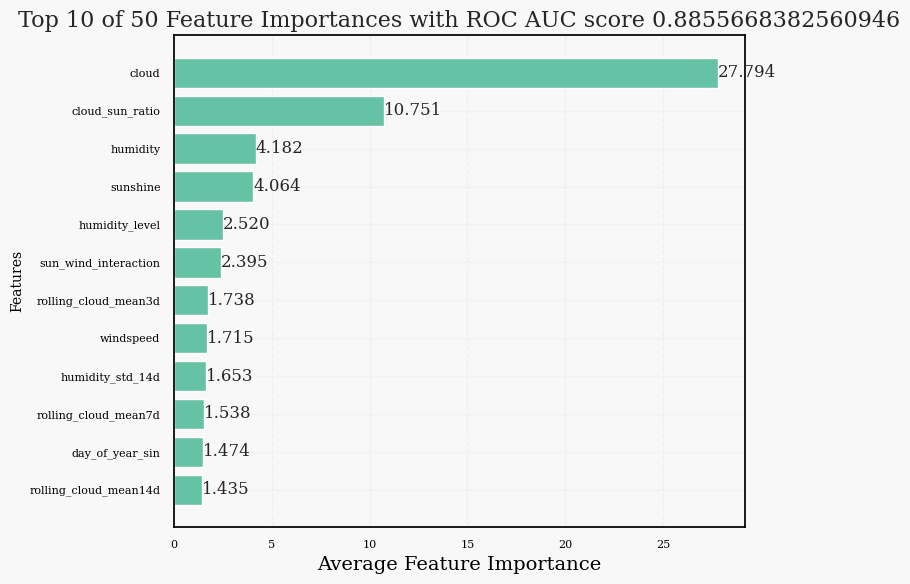

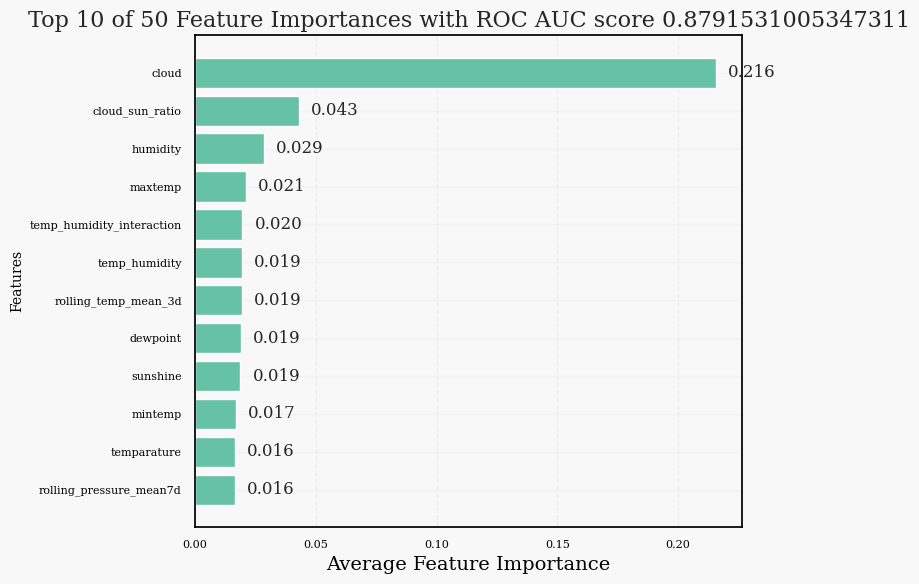

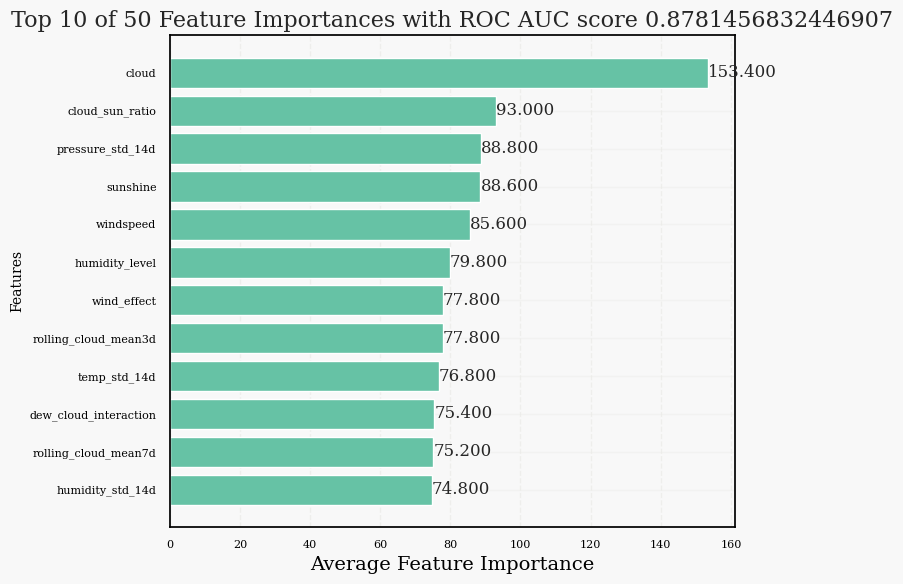

In [22]:
n_imp_features_cat=get_most_important_features(X.reset_index(drop=True), y,50,12, 'cat')
n_imp_features_xgb=get_most_important_features(X.reset_index(drop=True), y,50, 12, 'xgb')
n_imp_features_lgbm=get_most_important_features(X.reset_index(drop=True), y,50, 12, 'lgbm')

In [50]:
total_imp_features = [*set(n_imp_features_xgb+n_imp_features_lgbm+n_imp_features_cat)]
print(f'{len(total_imp_features)} features have been selected from three algorithms for the final model')

X = X[total_imp_features]
X_test = X_test[total_imp_features]

53 features have been selected from three algorithms for the final model


In [51]:
X_test.shape

(730, 53)

# Model Building

### 6.1 Class Weights

In [24]:
classes = np.unique(y)
class_to_index = {cls: idx for idx, cls in enumerate(classes)}
y_numeric = np.array([class_to_index[cls] for cls in y])

class_counts = np.bincount(y_numeric)
total_samples = len(y_numeric)

class_weights = total_samples/(len(classes)*class_counts)

class_wts_dict = {cls: wts for cls, wts in zip(classes, class_weights)}

print('Class counts:', class_counts)
print('Total Samples:', total_samples)
print('Class weights:', class_weights)
print('Class weights dictionary:', class_wts_dict)

Class counts: [ 657 1899]
Total Samples: 2556
Class weights: [1.94520548 0.67298578]
Class weights dictionary: {0: 1.9452054794520548, 1: 0.6729857819905213}


### 6.2 Models

In [25]:
def all_optimizers():
    sgd=tensorflow.keras.optimizers.SGD(learning_rate=0.005, momentum=0.5, nesterov=True)
    rms=tensorflow.keras.optimizers.RMSprop()
    nadam=tensorflow.keras.optimizers.Nadam(
        learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'
    )
    adam = tensorflow.keras.optimizers.Adam()
    adamW= keras.optimizers.AdamW(learning_rate=0.002, weight_decay=0.001, beta_1=0.9, beta_2=0.999)
    return sgd, rms, nadam, adamW, adam

def init_ann1(num_classes, input_dim):
    sgd, rms, nadam, adamW, adam = all_optimizers()
    ann = Sequential()

    ann.add(Dense(16, input_dim=X_test.shape[1], kernel_initializer='he_uniform', activation='relu'))
    ann.add(Dropout(0.1))
    ann.add(Dense(4, kernel_initializer='he_uniform', activation='relu'))
    ann.add(Dense(num_classes, kernel_initializer='he_uniform', activaiton='softmax'))

    ann.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return ann

def init_ann2(num_classes, input_dim):
    sgd, rms, nadam, adamW, adam = all_optimizers()
    ann = Sequential()

    ann.add(Dense(128, input_dim=X_test.shape[1], kernel_initializer='he_uniform', activation='relu'))
    ann.add(Dropout(0.3))
    ann.add(Dense(4, kernel_initializer='he_uniform', activation='relu'))
    ann.add(Dropout(0.2))
    ann.add(Dense(num_classes, kernel_initializer='he_uniform', activaiton='softmax'))

    ann.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return ann

In [26]:
# class Splitter:
#     def __init__(self, test_size=0.2, kFold=True, n_splits=10):
#         self.text_size = test_size
#         self.kfold = kFold
#         self.n_splits = n_splits

#     def split_data(self, X, y, random_state_list):
#         if self.kfold:
#             for random_state in random_state_list:
#                 kf = StratifiedKFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
#                 for train_idx, val_idx in kf.split(X, y):
#                     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#                     y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#                     yield X_train, X_val, y_train, y_val

# class Classifier:
#     def __init__(self, n_estimators=100, device='cpu', random_state=0):
#         self.n_estimators = n_estimators
#         self.device = device
#         self.random_state = random_state
#         self.models = self._define_model()

#     def _define_model(self):
#         xgb_params = {
#             'n_estimators': 775, 
#             'learning_rate': 0.011855184394903252, 
#             'max_depth': 4, 
#             'subsample': 0.7355233695313599, 
#             'colsample_bytree': 0.15766824176675961,
#             'n_jobs': -1,
#             'eval_metric': 'auc',
#             'objective': 'binary:logistic',
#             'tree_method': 'hist',
#             'verbosit':0,
#             'random_state': self.random_state
#         }

#         if self.device=='gpu':
#             xgb_params['tree_method']='gpu_hist'
#             xgb_params['predictor'] = 'gpu_predictor'

#         xgb_params_2 = {
#             'n_estimators': 217, 
#             'gamma': 2.3264337327711373, 
#             'max_depth': 15, 
#             'subsample': 0.7465262532316279, 
#             'min_child_weight': 18, 
#             'colsample_bytree': 0.3572697143307646, 
#             'learning_rate': 0.018815190994834825,
#             'reg_lambda': 0.00017748771547501784, 
#             'reg_alpha': 0.00048066870328382035,
#             'n_jobs': -1,
#             'eval_metric': 'auc',
#             'objective': 'binary:logistic',
#             'tree_method': 'hist',
#             'verbosity':0,
#             'random_state': self.random_state
#         }

#         xgb_params_3 = {
#             'n_estimators': 55, 
#             'gamma': 0.279, 
#             'max_depth': 10, 
#             'subsample': 0.325, 
#             'min_child_weight': 9, 
#             'colsample_bytree': 0.487, 
#             'learning_rate': 0.052, 
#             'reg_lambda': 0.0007, 
#             'reg_alpha': 0.371,
#             'n_jobs': -1,
#             'eval_metric': 'auc',
#             'objective': 'binary:logistic',
#             'tree_method': 'hist',
#             'verbosity': 0,
#             'device': 'cuda',
#             'booster': 'gbtree',
#             'random_state': self.random_state,
            
#         }

#         xgb_params_4 = xgb_params.copy()
#         xgb_params_4.update({
#             'learning_rate': 0.010115048702495482, 
#             'max_depth': 2, 
#             'subsample': 0.6639841647391995, 
#             'colsample_bytree': 0.3181370672109632
#         })

#         xgb_params_5 = {
#             'gamma': 0.48868260058185325,
#             'max_depth': 10,
#             'subsample': 0.48192360001125734,
#             'min_child_weight': 8,
#             'colsample_bytree': 0.1815610273361127,
#             'learning_rate': 0.049945885157814784,
#             'reg_lambda': 0.0742537889767154,
#             'reg_alpha': 0.009305232782375435,
#             'n_jobs': -1,
#             'eval_metric': 'auc',
#             'objective': 'binary:logistic',
#             'tree_method': 'hist',
#             'verbosity': 0,
#             'device': 'cuda',
#             'booster': 'gbtree',
#             'random_state': self.random_state,
#         }

#         # LightGBM parameters
#         lgb_params ={
#             'n_estimators': 149, 
#             'max_depth': 11, 
#             'learning_rate': 0.0753097600630585, 
#             'num_leaves': 148, 
#             'subsample': 0.5632894858727845, 
#             'colsample_bytree': 0.5153101890250398, 
#             'reg_alpha': 8.176699066960696, 
#             'reg_lambda': 9.293137598504012, 
#             'min_child_samples': 34,
#             'verbose': -1
#         }
        
#         lgb_params_2={
#             'n_estimators': 530, 
#             'max_depth': 4, 
#             'min_samples_leaf': 49, 
#             'subsample': 0.8387650607687551, 
#             'learning_rate': 0.00699546078479003, 
#             'lambda_l1': 0.0001041174884731989, 
#             'lambda_l2': 9.772675193152315e-06,
#             'objective': 'binary',  
#             'metric': 'auc',  
#             'boosting_type': 'gbdt',
#             'device': self.device,
#             'random_state': self.random_state,
#             'verbose': -1
#         }

#         lgb_params_3={
#             'n_estimators': 838, 
#             'max_depth': 4, 
#             'min_samples_leaf': 50, 
#             'subsample': 0.567466112695905, 
#             'learning_rate': 0.00409222968906551, 
#             'lambda_l1': 1.3507375148813217e-05, 
#             'lambda_l2': 1.9026573417276475e-05,
#             "objective": "binary", 
#             "metric": "auc", 
#             "boosting_type": "gbdt",
#             "device": "gpu", 
#             "random_state": 42,
#             "verbose": -1,
#         }

#         lgb_params_4 = {
#             'n_estimators': 290,
#             'max_depth': 3, 
#             'subsample': 0.763088551177673,
#             'learning_rate': 0.009548273536020955,
#             'lambda_l1': 0.005742328369462262,
#             'lambda_l2': 0.0002773703324165552, 
#             'colsample_bytree': 0.3130914518557212, 
#             "objective": "binary",  
#             "metric": "auc", 
#             "boosting_type": "gbdt",  
#             "device": "gpu",  
#             "random_state": 42,  
#             "verbose": -1  
#         }
#         lgb_params_5 = lgb_params_3.copy()
#         lgb_params_5.update({
#             'subsample': 0.7733012046009582, 
#             'learning_rate': 0.005016108167592575, 
#             'lambda_l1': 4.336654929394266e-05, 
#             'lambda_l2': 4.973087371837805e-06, 
#             'colsample_bytree': 0.30246614105831615
#         })

#         cb_params = {
#             'iterations': 116, 
#             'depth': 5, 
#             'learning_rate': 0.04683853799603651, 
#             'l2_leaf_reg': 5.3104323053527445, 
#             'random_strength': 0.9958446006996191, 
#             'max_bin': 166,
#             'od_wait': 94, 
#             'one_hot_max_size': 11, 
#             'grow_policy': 'Lossguide', 
#             'bootstrap_type': 'MVS',
#             'od_type': 'IncToDec',
#             'eval_metric': 'AUC',
#             'loss_function': 'Logloss',  # Changed to binary
#             'task_type': self.device.upper(),
#             'random_state': self.random_state,
#             'verbose': 0
#         }

#         cb_sym_params = cb_params.copy()
#         cb_sym_params['grow_policy'] = 'SymmetricTree'
    
#         cb_loss_params = cb_params.copy()
#         cb_loss_params['grow_policy'] = 'Lossguide'

#         cb_params_2={
#            'iterations': 191, 
#            'depth': 6, 
#            'learning_rate': 0.10270575540801155, 
#            'l2_leaf_reg': 5.698224228684186, 
#            'border_count': 152, 
#            'bagging_temperature': 0.2714694258832317, 
#            'random_strength': 4.293029464079092, 
#            'od_wait': 25,
#            'grow_policy': 'Depthwise',
#            'bootstrap_type': 'Bayesian',
#            'od_type': 'Iter',
#            'eval_metric': 'AUC',
#            'loss_function': 'Logloss',  # Changed to binary
#            'task_type': self.device.upper(),
#            'random_state': self.random_state,
#            'verbose': 0
#         }
#         cb_params_3=cb_params_2.copy()
#         cb_params_3={
#            'depth': 10, 
#            'learning_rate': 0.015084884687215316,
#            'l2_leaf_reg': 2.4683101270243735, 
#            'random_strength': 0.51156406971452,
#            'max_bin': 150, 
#            'one_hot_max_size': 69,
#            'od_wait': 65
#         }

#         cb_params_4=cb_params.copy()
#         cb_params_4={
#            'iterations': 465,
#            'depth': 4, 
#            'learning_rate': 0.03475272365315816, 
#            'l2_leaf_reg': 7.794643129433652,
#            'random_strength': 9.928152021606452,
#            'od_wait': 82, 
#            'grow_policy': 'Depthwise',
#            'bootstrap_type': 'MVS'
#         }

#         models = {
#            'xgb': XGBClassifier(**xgb_params),
#            'xgb2': XGBClassifier(**xgb_params_2),
#            'xgb3': XGBClassifier(**xgb_params_3),
#            # 'xgb4': XGBClassifier(**xgb_params_4),
#            # 'xgb5': XGBClassifier(**xgb_params_5),

#            'lgb': LGBMClassifier(**lgb_params),
#            'lgb2': LGBMClassifier(**lgb_params_2),
#            # 'lgb3': LGBMClassifier(**lgb_params_3),
#            # 'lgb4': LGBMClassifier(**lgb_params_4),
#            # 'lgb5': LGBMClassifier(**lgb_params_5),

#            # 'cb': CatBoostClassifier(**cb_params),
#            # 'cb_sym': CatBoostClassifier(**cb_sym_params),
#            # 'cb_loss': CatBoostClassifier(**cb_loss_params),
#            # 'cb2': CatBoostClassifier(**cb_params_2),
#            # 'cb3': CatBoostClassifier(**cb_params_3),
#            # 'cb4': CatBoostClassifier(**cb_params_4),
#         }

#         return models


In [52]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
X_test.shape

(730, 53)

In [29]:
!!pip install cmaes

['Collecting cmaes',
 '  Downloading cmaes-0.11.1-py3-none-any.whl.metadata (18 kB)',
 'Requirement already satisfied: numpy in /usr/local/lib/python3.10/dist-packages (from cmaes) (1.26.4)',
 'Requirement already satisfied: mkl_fft in /usr/local/lib/python3.10/dist-packages (from numpy->cmaes) (1.3.8)',
 'Requirement already satisfied: mkl_random in /usr/local/lib/python3.10/dist-packages (from numpy->cmaes) (1.2.4)',
 'Requirement already satisfied: mkl_umath in /usr/local/lib/python3.10/dist-packages (from numpy->cmaes) (0.1.1)',
 'Requirement already satisfied: mkl in /usr/local/lib/python3.10/dist-packages (from numpy->cmaes) (2025.0.1)',
 'Requirement already satisfied: tbb4py in /usr/local/lib/python3.10/dist-packages (from numpy->cmaes) (2022.0.0)',
 'Requirement already satisfied: mkl-service in /usr/local/lib/python3.10/dist-packages (from numpy->cmaes) (2.4.1)',
 'Requirement already satisfied: intel-openmp>=2024 in /usr/local/lib/python3.10/dist-packages (from mkl->numpy->c

In [30]:
from copy import deepcopy 
import time

In [54]:
print(X.shape,y.shape)
print(X_test.shape)

(2556, 53) (2556,)
(730, 53)


In [73]:
import numpy as np
import pandas as pd
import gc
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from copy import deepcopy
import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from functools import partial

class Splitter:
    def __init__(self, test_size=0.2, kfold=True, n_splits=10):
        self.test_size = test_size
        self.kfold = kfold
        self.n_splits = n_splits

    def split_data(self, X, y, random_state_list):
        if self.kfold:
            for random_state in random_state_list:
                kf = StratifiedKFold(n_splits=self.n_splits, shuffle=True)
                for train_idx, val_idx in kf.split(X, y):
                    yield X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]

class Classifier:
    def __init__(self, n_estimators=100, device='cpu', random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._define_model()

    def _define_model(self):
        xgb_params = {
            'n_estimators': 775, 
            'learning_rate': 0.0118, 
            'max_depth': 4, 
            'subsample': 0.7355, 
            'colsample_bytree': 0.1577,
            'n_jobs': -1,
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            'tree_method': 'hist',
            'verbosity': 0,
            'random_state': self.random_state
        }

        if self.device == 'gpu':
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['predictor'] = 'gpu_predictor'

        xgb_params_2 = {
            'n_estimators': 217, 
            'gamma': 2.326, 
            'max_depth': 15, 
            'subsample': 0.7465, 
            'min_child_weight': 18, 
            'colsample_bytree': 0.3573, 
            'learning_rate': 0.0188,
            'reg_lambda': 0.000177, 
            'reg_alpha': 0.000480,
            'n_jobs': -1,
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            'tree_method': 'hist',
            'verbosity': 0,
            'random_state': self.random_state
        }

        xgb_params_3 = {
            'n_estimators': 55, 
            'gamma': 0.279, 
            'max_depth': 10, 
            'subsample': 0.325, 
            'min_child_weight': 9, 
            'colsample_bytree': 0.487, 
            'learning_rate': 0.052, 
            'reg_lambda': 0.0007, 
            'reg_alpha': 0.371,
            'n_jobs': -1,
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            'tree_method': 'hist',
            'verbosity': 0,
            'device': 'cuda',
            'booster': 'gbtree',
            'random_state': self.random_state,
            
        }

        lgb_params ={
            'n_estimators': 149, 
            'max_depth': 11, 
            'learning_rate': 0.0753097600630585, 
            'num_leaves': 148, 
            'subsample': 0.5632894858727845, 
            'colsample_bytree': 0.5153101890250398, 
            'reg_alpha': 8.176699066960696, 
            'reg_lambda': 9.293137598504012, 
            'min_child_samples': 34,
            'verbose': -1
        }
        
        lgb_params_2={
            'n_estimators': 530, 
            'max_depth': 4, 
            'min_samples_leaf': 49, 
            'subsample': 0.8387650607687551, 
            'learning_rate': 0.00699546078479003, 
            'lambda_l1': 0.0001041174884731989, 
            'lambda_l2': 9.772675193152315e-06,
            'objective': 'binary',  
            'metric': 'auc',  
            'boosting_type': 'gbdt',
            'device': self.device,
            'random_state': self.random_state,
            'verbose': -1
        }

        lgb_params_3={
            'n_estimators': 838, 
            'max_depth': 4, 
            'min_samples_leaf': 50, 
            'subsample': 0.567466112695905, 
            'learning_rate': 0.00409222968906551, 
            'lambda_l1': 1.3507375148813217e-05, 
            'lambda_l2': 1.9026573417276475e-05,
            "objective": "binary", 
            "metric": "auc", 
            "boosting_type": "gbdt",
            "device": "gpu", 
            "random_state": 42,
            "verbose": -1,
        }
        knn_params = {'n_neighbors':101, "p":1}

        models = {
            # 'xgb': XGBClassifier(**xgb_params),
            'xgb2': XGBClassifier(**xgb_params_2),
            'xgb3': XGBClassifier(**xgb_params_3),

           # 'lgb': LGBMClassifier(**lgb_params),
           'lgb2': LGBMClassifier(**lgb_params_2),
           'lgb3': LGBMClassifier(**lgb_params_3),
           'knn': KNeighborsClassifier(**knn_params),
           'svm': SVC(probability=True, random_state=self.random_state),
        }

        return models

In [76]:
class OptunaWeights:
    """
    Advanced ensemble weight optimization using Optuna.
    This class optimizes weights for model predictions to maximize classification metrics.
    """
    def __init__(self, random_state, n_trials=5000, metric='auc', 
                 sampler_type='tpe', direction='maximize', timeout=None):
        """
        Initialize the OptunaWeights class.
        
        Args:
            random_state (int): Random seed for reproducibility
            n_trials (int): Number of optimization trials
            metric (str): Metric to optimize ('auc', 'logloss', 'accuracy', 'f1')
            sampler_type (str): Type of sampler ('tpe', 'cmaes', 'random')
            direction (str): Optimization direction ('maximize' or 'minimize')
            timeout (int): Maximum time in seconds for optimization (None = no limit)
        """
        self.study = None
        self.weights = None
        self.random_state = random_state
        self.n_trials = n_trials
        self.metric = metric
        self.sampler_type = sampler_type
        self.direction = direction
        self.timeout = timeout
        self.best_score = None
        self.calibrated_threshold = 0.5  # Default threshold

    def _find_best_threshold(self, y_true, y_pred):
        """Find the optimal classification threshold."""
        best_threshold = 0.5
        best_f1 = 0
        
        # Test thresholds from 0.01 to 0.99 with 0.01 increments
        for threshold in np.arange(0.01, 1.0, 0.01):
            y_pred_binary = (y_pred > threshold).astype(int)
            f1 = f1_score(y_true, y_pred_binary)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
                
        return best_threshold
    
    def _validate_inputs(self, y_true, y_preds):
        """Validate input shapes and types."""
        if not isinstance(y_preds, list):
            raise ValueError("y_preds must be a list of prediction arrays")
        
        if len(y_preds) == 0:
            raise ValueError("Empty predictions list")
            
        # Convert to numpy arrays if needed
        y_preds_np = []
        for pred in y_preds:
            if isinstance(pred, np.ndarray):
                y_preds_np.append(pred)
            else:
                y_preds_np.append(np.array(pred))
                
        # Validate shapes
        for i, pred in enumerate(y_preds_np):
            if pred.shape[0] != y_true.shape[0]:
                raise ValueError(f"Shape mismatch in model {i}: {pred.shape} vs {y_true.shape}")
                
        return y_true, y_preds_np

    def _objective(self, trial, y_true, y_preds):
        """Optimization objective function."""
        # Define the weights for the predictions from each model
        weights = []
        for n in range(len(y_preds)):
            # Allow negative weights, which can be useful for certain ensembles
            weight = trial.suggest_float(f"weight{n}", -2, 2)
            weights.append(weight)
        
        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds), axis=0, weights=weights)
        
        # Normalize predictions to ensure they sum to 1 across classes
        if len(weighted_pred.shape) > 1 and weighted_pred.shape[1] > 1:
            # Multi-class case
            weighted_pred = weighted_pred / weighted_pred.sum(axis=1, keepdims=True)
        else:
            # Binary classification case - clip values to valid probability range
            weighted_pred = np.clip(weighted_pred, 0, 1)
        
        # Calculate metric based on selected option
        if self.metric == 'logloss':
            # For log loss, we want to minimize
            return log_loss(y_true, weighted_pred)
        elif self.metric == 'accuracy':
            threshold = trial.suggest_float("threshold", 0.1, 0.9)
            weighted_pred_labels = (weighted_pred > threshold).astype(int)
            return accuracy_score(y_true, weighted_pred_labels)
        elif self.metric == 'f1':
            threshold = trial.suggest_float("threshold", 0.1, 0.9)
            weighted_pred_labels = (weighted_pred > threshold).astype(int)
            return f1_score(y_true, weighted_pred_labels)
        else:
            # Default to AUC
            return roc_auc_score(y_true, weighted_pred)

    def fit(self, y_true, y_preds, cv=None):
        """
        Fit the model to optimize ensemble weights.
        
        Args:
            y_true: True labels
            y_preds: List of model predictions
            cv: Optional cross-validation strategy for more robust weight optimization
        """
        # Validate inputs
        y_true, y_preds = self._validate_inputs(y_true, y_preds)
        
        # Set optimization verbosity
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        
        # Choose sampler based on configuration
        if self.sampler_type == 'cmaes':
            sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        elif self.sampler_type == 'random':
            sampler = optuna.samplers.RandomSampler(seed=self.random_state)
        else:
            # Default to TPE sampler which often works better than CMA-ES for this problem
            sampler = TPESampler(seed=self.random_state, multivariate=True)
        
        # Set pruner for early stopping
        pruner = optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=5)
        
        # Set optimization direction
        direction = self.direction
        if self.metric == 'logloss':
            # For log loss, we always want to minimize
            direction = 'minimize'
        
        # Create study
        self.study = optuna.create_study(
            sampler=sampler, 
            pruner=pruner, 
            study_name="OptunaWeights", 
            direction=direction
        )
        
        if cv is not None and cv > 1:
            # Use cross-validation for more robust weight optimization
            skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=self.random_state)
            cv_scores = []
            
            for train_idx, val_idx in skf.split(np.zeros(len(y_true)), y_true):
                y_true_val = y_true[val_idx]
                y_preds_val = [pred[val_idx] for pred in y_preds]
                
                # Optimize on this fold
                objective_partial = partial(self._objective, y_true=y_true_val, y_preds=y_preds_val)
                fold_study = optuna.create_study(sampler=sampler, direction=direction)
                fold_study.optimize(
                    objective_partial, 
                    n_trials=self.n_trials // cv,
                    timeout=None if self.timeout is None else self.timeout // cv
                )
                cv_scores.append(fold_study.best_value)
            
            # Re-optimize on full dataset with more knowledge
            objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
            self.study.optimize(
                objective_partial, 
                n_trials=self.n_trials,
                timeout=self.timeout
            )
        else:
            # Standard optimization on the full dataset
            objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
            self.study.optimize(
                objective_partial, 
                n_trials=self.n_trials,
                timeout=self.timeout
            )
        
        # Extract the best weights
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]
        
        # Record the best score
        self.best_score = self.study.best_value
        
        # Find optimal threshold (for classification metrics)
        if 'threshold' in self.study.best_params:
            self.calibrated_threshold = self.study.best_params['threshold']
        else:
            weighted_pred = self.predict(y_preds)
            self.calibrated_threshold = self._find_best_threshold(y_true, weighted_pred)
        
        return self

    def predict(self, y_preds, normalize=True):
        """
        Make predictions using optimized weights.
        
        Args:
            y_preds: List of model predictions
            normalize: Whether to normalize predictions
            
        Returns:
            Weighted prediction
        """
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        
        # Convert to numpy arrays if needed
        y_preds_np = []
        for pred in y_preds:
            if isinstance(pred, np.ndarray):
                y_preds_np.append(pred)
            else:
                y_preds_np.append(np.array(pred))
        
        # Calculate weighted predictions
        weighted_pred = np.average(np.array(y_preds_np), axis=0, weights=self.weights)
        
        # Normalize if requested
        if normalize:
            if len(weighted_pred.shape) > 1 and weighted_pred.shape[1] > 1:
                # Multi-class case
                weighted_pred = weighted_pred / weighted_pred.sum(axis=1, keepdims=True)
            else:
                # Binary classification - clip to valid probability range
                weighted_pred = np.clip(weighted_pred, 0, 1)
                
        return weighted_pred

    def predict_classes(self, y_preds):
        """
        Predict class labels using the optimized threshold.
        
        Args:
            y_preds: List of model predictions
            
        Returns:
            Class predictions
        """
        weighted_pred = self.predict(y_preds)
        return (weighted_pred > self.calibrated_threshold).astype(int)

    def fit_predict(self, y_true, y_preds, normalize=True):
        """
        Fit the model and return predictions in one step.
        
        Args:
            y_true: True labels
            y_preds: List of model predictions
            normalize: Whether to normalize predictions
            
        Returns:
            Weighted prediction
        """
        self.fit(y_true, y_preds)
        return self.predict(y_preds, normalize=normalize)

    def get_weights(self):
        """Return the optimized weights."""
        if self.weights is None:
            raise ValueError("Model has not been fitted yet")
        return self.weights
    
    def get_feature_importance(self):
        """
        Get the relative importance of each model in the ensemble.
        
        Returns:
            Dictionary mapping index to relative importance
        """
        if self.weights is None:
            raise ValueError("Model has not been fitted yet")
            
        # Get absolute weights
        abs_weights = np.abs(self.weights)
        total = np.sum(abs_weights)
        
        # Normalize to get relative importance
        if total > 0:
            importance = abs_weights / total
        else:
            importance = np.ones_like(abs_weights) / len(abs_weights)
            
        return {i: float(imp) for i, imp in enumerate(importance)}
    
    def get_search_statistics(self):
        """
        Get statistics from the optimization process.
        
        Returns:
            Dictionary with optimization statistics
        """
        if self.study is None:
            raise ValueError("Model has not been fitted yet")
            
        return {
            "best_score": self.best_score,
            "best_trial": self.study.best_trial.number,
            "n_trials": len(self.study.trials),
            "optimization_direction": self.study.direction.name,
            "calibrated_threshold": self.calibrated_threshold
        }

In [77]:
X_test.shape

(730, 53)

In [ ]:
import numpy as np
import pandas as pd
import time
import gc
from copy import deepcopy
from sklearn.metrics import roc_auc_score

# Configuration
kfold = True
n_splits = 5 if kfold else 1
random_state = 42
random_state_list = [random_state]
n_estimators = 9999
early_stopping_rounds = 300
verbose = False

# Initialize splitter and storage
splitter = Splitter(kfold=kfold, n_splits=n_splits)
oof_predss = pd.DataFrame(np.zeros((X_train.shape[0], 1)), index=X_train.index)
test_predss = np.zeros((X_test.shape[0], 1))
ensemble_acc_score = []
weights = []
trained_models = {'xgb': []}
best_thresholds = []

for i, (X_train_, X_val, y_train_, y_val) in enumerate(splitter.split_data(X, y, random_state_list=random_state_list)):
    n = i % n_splits
    m = i // n_splits
    
    classifier = Classifier(n_estimators, device, random_state)
    models = classifier.models
    
    oof_preds, test_preds = [], []
    start_time_fold = time.time()
    
    for name, model in models.items():
        start_time = time.time()
        
        # Model fitting
        if ('xgb' in name) or ('lgb' in name) or ('cat' in name):
           if 'lgb' in name:
               model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)])
           elif 'cat' in name:
               model.fit(X_train_, y_train_, 
                        eval_set=[(X_val, y_val)],
                        early_stopping_rounds=early_stopping_rounds,#cat_features=cat_features,
                        verbose=verbose)  
           else:
               model.fit(X_train_, y_train_, 
                        eval_set=[(X_val, y_val)],
                        early_stopping_rounds=early_stopping_rounds,
                        verbose=verbose)

        elif 'ann' in name:
           model.fit(X_train_, y_train_,
                    validation_data=(X_val, y_val),
                    batch_size=16,
                    epochs=10,
                    verbose=verbose)
        else:
           model.fit(X_train_, y_train_)
        
        # Store trained models
        if name in trained_models:
            trained_models[name].append(deepcopy(model))
        
        # Make predictions
        if 'ann' in name:
            y_val_pred = model.predict(X_val).reshape(-1, 1)
            test_pred = model.predict(X_test).reshape(-1, 1)
        else:
            y_val_pred = model.predict_proba(X_val)[:, 1].reshape(-1, 1)
            test_pred = model.predict_proba(X_test)[:, 1].reshape(-1, 1)
        
        # Scoring
        score = roc_auc_score(y_val, y_val_pred)
        print(f'{name} [FOLD-{n} SEED-{random_state_list[m]}] AUC: {score:.5f} | Time: {time.time() - start_time:.3f} secs')
        
        oof_preds.append(y_val_pred)
        test_preds.append(test_pred)
    
    # Optimize ensemble weights
    optweights = OptunaWeights(random_state=random_state, n_trials=3000, metric='auc')
    y_val_pred = optweights.fit_predict(y_val, oof_preds)
    
    # Ensure index alignment before assignment
    valid_indices = X_val.index.intersection(oof_predss.index)
    oof_predss.loc[valid_indices] = y_val_pred[:len(valid_indices)]


    
    fold_score = roc_auc_score(y_val, y_val_pred)
    print(f'Ensemble [FOLD-{n} SEED-{random_state_list[m]}] ---> AUC: {fold_score:.5f} | Fold Time: {time.time() - start_time_fold:.3f} secs')
    
    ensemble_acc_score.append(fold_score)
    weights.append(optweights.weights)
    
    # Predict test data using ensemble weights
    test_preds = optweights.predict(test_preds)
    test_predss += test_preds / (n_splits * len(random_state_list))
    
    gc.collect()

xgb2 [FOLD-0 SEED-42] AUC: 0.89771 | Time: 0.470 secs
xgb3 [FOLD-0 SEED-42] AUC: 0.89689 | Time: 0.228 secs
lgb2 [FOLD-0 SEED-42] AUC: 0.89081 | Time: 0.936 secs
lgb3 [FOLD-0 SEED-42] AUC: 0.89115 | Time: 1.427 secs
knn [FOLD-0 SEED-42] AUC: 0.87107 | Time: 0.093 secs
svm [FOLD-0 SEED-42] AUC: 0.86898 | Time: 0.739 secs


/usr/local/lib/python3.10/dist-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


In [66]:
from optuna.samplers import TPESampler
from sklearn.svm import SVC

sampler = TPESampler(seed=random_state, multivariate=True)

/usr/local/lib/python3.10/dist-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


In [71]:
print(f"\nEnsemble CV Accuracy: {np.mean(ensemble_acc_score):.5f} ± {np.std(ensemble_acc_score):.5f}")

# Print the mean and standard deviation of the ensemble weights for each model
print('--- Model Weights ---')
mean_weights = np.mean(weights, axis=0)
std_weights = np.std(weights, axis=0)
for name, mean_weight, std_weight in zip(models.keys(), mean_weights, std_weights):
    print(f'{name}: {mean_weight:.5f} ± {std_weight:.5f}')


Ensemble CV Accuracy: 0.89709 ± 0.00760
--- Model Weights ---
xgb2: -0.10310 ± 1.47814
xgb3: -0.82945 ± 1.08056
knn: 0.03757 ± 0.13077
svm: -0.66945 ± 0.64850


In [72]:
oof_predss.to_csv('oof_predss.csv',index=False)

sub[target] =  test_predss
sub.to_csv('submission.csv',index=False)

sub.head()

,id,rainfall
0,2190,0.884230
1,2191,0.895359
2,2192,0.876708
3,2193,0.198162
4,2194,0.224289
